In [3]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = scipy.io.loadmat('/Users/dhruvkulshrestha/Desktop/FNO1D/burgers_data_R10.mat')
u = data['u']  # shape: (Nt, Nx)

u = torch.tensor(u, dtype=torch.float64)
u = u.unsqueeze(0)  # shape: (1, Nt, Nx)


u = u[:, :512, ::8]  # reduce time and space resolution
Nt, Nx = u.shape[1], u.shape[2]
x = np.linspace(0, 1, Nx)
t_tensor = torch.linspace(0, 1, Nt, dtype=torch.float64)


In [5]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, u):
        t_tensor = torch.ones_like(u) * t
        input = torch.cat([u, t_tensor], dim=1)
        return self.net(input)

In [6]:
class NeuralODE(nn.Module):
    def __init__(self, odefunc):
        super(NeuralODE, self).__init__()
        self.odefunc = odefunc

    def forward(self, u0, t):
        return odeint(self.odefunc, u0, t)

In [7]:
def get_burgers_data(n_points=100, n_time=20):
    x = torch.linspace(0, 1, n_points).view(-1, 1)
    t = torch.linspace(0, 1, n_time)
    X, T = torch.meshgrid(x.squeeze(), t, indexing='ij')
    u = -torch.sin(torch.pi * X) * torch.exp(-T)
    return x, t, u


In [8]:
x, t, u_true = get_burgers_data()
u0 = u_true[:, 0].unsqueeze(1)
t_tensor = t


In [9]:
func = ODEFunc()
model = NeuralODE(func)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 200
for epoch in range(n_epochs):
    pred_u = model(u0, t_tensor)
    pred_u = pred_u.squeeze(-1).permute(1, 0)  # (space, time)
    loss = loss_fn(pred_u, u_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.035188
Epoch 20, Loss: 0.004736
Epoch 40, Loss: 0.001542
Epoch 60, Loss: 0.000625
Epoch 80, Loss: 0.000251
Epoch 100, Loss: 0.000097
Epoch 120, Loss: 0.000037
Epoch 140, Loss: 0.000015
Epoch 160, Loss: 0.000007
Epoch 180, Loss: 0.000004


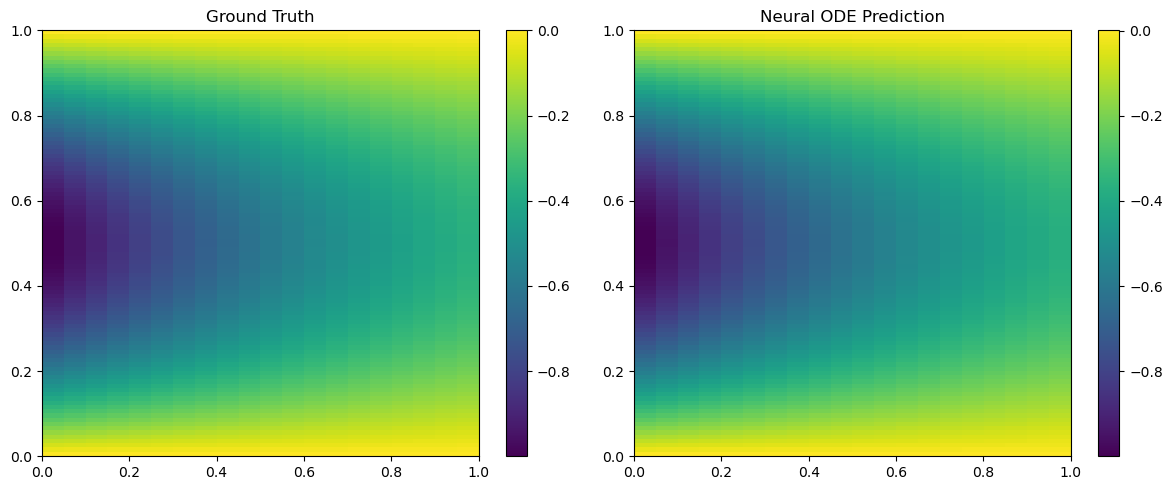

In [10]:
with torch.no_grad():
    pred_u = model(u0, t_tensor).squeeze(-1).permute(1, 0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(u_true, aspect='auto', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Neural ODE Prediction")
plt.imshow(pred_u, aspect='auto', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar()

plt.tight_layout()
plt.show()